In [38]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp  
import random
import math
import xgboost as xgb
from tqdm import tqdm
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split


In [39]:
def Corr(l1,l2):
    '''
    ## Description:
        Correlation function between two lists of the same length.

    ## Returns:
        corr (float): correlation between the two lists

    ## Parameters:
        l1 (list): list of predictions of the first classifier (1 or 0)
        l2 (list): list of predicions of the second classifier / true values (1 or 0)
    '''

    N = len(l1)
    # Get the correlation
    corr = 0
    for i in range(len(l1)):
        corr += (2*l1[i]-1)*(2*l2[i]-1)  # Scaling to -1,1
    return corr

In [40]:
def QUBO(L, x, y, lambda_):
    '''
    ## Description:
        Defines QUBO problem

    ## Returns:
    Q: QUBO matrix


    ## Parameters:
        L: list of weak classifiers (0 and 1)
        x: data
        y: labels
        lambda_: regularization parameter
    '''
    N = len(L)
    S = len(x)

    # Define QUBO matrix
    Q = np.zeros((N, N))

    for i in range(N):
        for j in range(i, N):
            if j != i:
                Q[i, j] = Corr(L[i].predict(x), L[j].predict(x))/N**2
                Q[j, i] = Q[i, j]
            else:
                Q[i, i] = lambda_ - 2*Corr(np.array(L[i].predict(x)), np.array(y))/N + S/N**2


    return Q


In [41]:
def simulated_annealing(func, init_state, T, reanneal, max_iter):
    """
        ## Description:
            Simulated annealing algorithm
            Finds the minimum of a function func using simulated annealing.

        ## Returns:
            current_state: final solution
            current_energy: final energy

        ## Parameters:
            func: function to minimize
            init_state (array of 0 and 1): initial solution
            T: initial temperature
            reanneal: number of iterations before reannealing
            max_iter: maximum number of iterations
    """

    # Initialize
    current_state = init_state
    current_energy = func(current_state)

    for iteration in range(max_iter):
        new_state = current_state.copy()

        # Flip one bit
        index = np.random.randint(0,len(new_state))
        new_state[index] = 1 - new_state[index]

        # Compute new energy
        new_energy = func(new_state)

        # If new energy is lower, accept new state
        if new_energy < current_energy:
            current_state = new_state
            current_energy = new_energy
        
        # If new energy is higher, accept new state with probability
        else:
            p = np.exp(-(new_energy - current_energy)/T)      # Compute probability
            if np.random.rand() < p:
                current_state = new_state
                current_energy = new_energy
        
        # Update temperature
        if iteration % reanneal == 0:
            T = T*0.95
    
    return current_state, current_energy  

In [42]:
def RGS(L,x,y,lambda_):
    '''
    ## Description:
        Implements RGS method using weak classifiers and Simulated Annealing

    ## Returns:
    w (array): solution of the QUBO problem

    ## Parameters:
        L (list): list of weak classifiers
        x (array): data
        y (array): labels
        lambda_ (scalar): regularization parameter
    '''

    # Define QUBO matrix
    Q = QUBO(L,x,y,lambda_)

    # Define QUBO problem
    
    def f(w):
        s=0
        for i in range(len(w)):
            for j in range(len(w)):
                s+= Q[i,j]*w[i]*w[j]
        return s
    
    # Define initial state
    init_state = np.zeros(len(L))
    
    # Run simulated annealing
    w, energy = simulated_annealing(f,init_state,1,40,1000)

    return w, energy


In [43]:
def PredictRGS(L,w,x):
    
    N = len(L)
    S = len(x)
    
    predictions = []

    for i in range(N):
        predictions.append(2 * L[i].predict(x) - 1)

    predictions = np.array(predictions)

    # Calculate T
    T = 0
    for i in range(S):
        for j in range(N):
            T+= w[j]*predictions[j][i]
    T = np.sign(T)

    # Calculate predictions 
    C = []
    for i in range(S):
        p = 0
        for j in range(N):
            p += w[j]*predictions[j][i]
        p = np.sign(p-T)
        C.append(p)
    
    # Replace -1 by 0
    for i in range(len(C)):
        if C[i] == -1:
            C[i] = 0
    return C


In [44]:
def PredictRGS_probas(L,w,x):

    N = len(L)
    S = len(x)
    
    y_score = []
    predictions = []

    for j in range(N):
        predictions.append(L[j].predict(x))

    for i in range(S):
        score = 0
        for j in range(N):
            score += w[j]*predictions[j][i]
        score = score/sum(w)
        y_score.append(score)
    
    return y_score

In [45]:
adult  = pd.read_csv("adult.csv", sep=',',header=0)
adult = adult.drop('education', axis=1)
adult.replace(['Cambodia', 'China', 'Hong', 'India','Iran', 'Japan', 'Laos', 'Philippines','Taiwan', 'Thailand','Vietnam'],'Asia', inplace = True)
adult.replace(['Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', 'El-Salvador','Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua','Peru', 'Puerto-Rico', 'Trinadad&Tobago', 'South'], 'Center & South America', inplace = True)
adult.replace(['England', 'France', 'Germany', 'Greece', 'Holand-Netherlands', 'Hungary', 'Ireland', 'Italy', 'Poland', 'Portugal', 'Scotland', 'Yugoslavia'], 'Europe', inplace = True)
adult.replace(['United-States', 'Canada'], 'Canada&USA', inplace = True)

In [46]:
features = adult.drop('income', axis = 1)

target = []
for x in adult['income']:
    if x == '>50K':
        target.append(1)
    else: 
        target.append(0)


features_matrix = pd.get_dummies(features)

# Replace bools by 0 and 1
features_matrix.replace([False, True], [0, 1], inplace = True)

In [47]:
# Looking at the distribution of the labels (in percentage)
print('Percentage of people with income >50K: ', round(sum(target)/len(target)*100,2), '%')
print('Percentage of people with income <=50K: ', round((1-sum(target)/len(target))*100,2), '%')

Percentage of people with income >50K:  23.93 %
Percentage of people with income <=50K:  76.07 %


In [48]:
# Split data into training and test sets

x_train, x_test, y_train, y_test = train_test_split(features_matrix, target, test_size=0.2, random_state=42)

**RANDOM FOREST**
(max_depth = 5)

<Axes: >

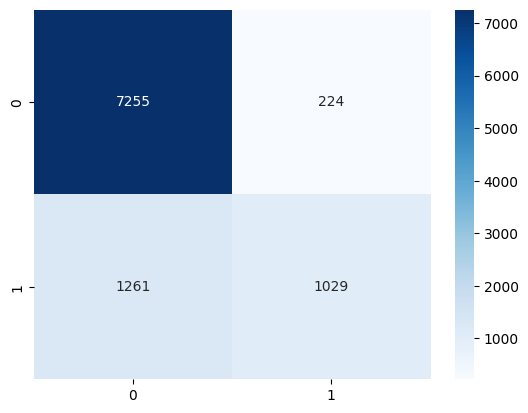

In [49]:
# Training a random forest classifier

clf = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=0)
clf.fit(x_train, y_train)

# Printing a confusion matrix using seaborn with better colors

y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

In [50]:
# Recall and precision of the RF
recall = cm[1,1]/(cm[1,1]+cm[1,0])
precision = cm[1,1]/(cm[1,1]+cm[0,1])
print('Recall: ', recall)
print('Precision: ', precision)

Recall:  0.4493449781659389
Precision:  0.8212290502793296


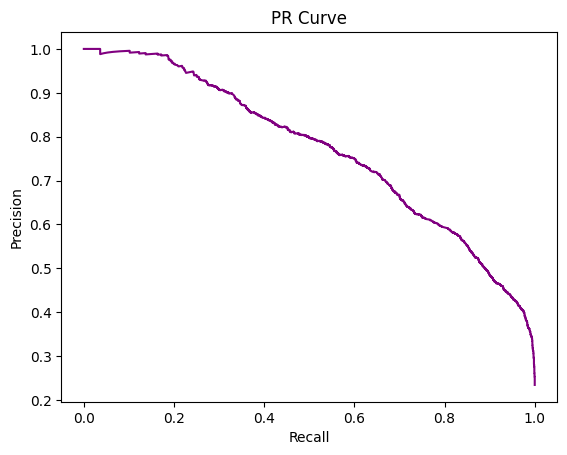

0.7691207884324105

In [51]:
# PR Curve
y_score = clf.predict_proba(x_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_score)
fig, ax  = plt.subplots()
ax.plot(recall, precision, color = "purple")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR Curve")
plt.show()

# AUC
auc(recall, precision)

**QBOOST**

In [52]:
# Training 60 decision trees
from sklearn.tree import DecisionTreeClassifier

L = []
for i in range(50):
    x_train_small, _, y_train_small, _ = train_test_split(x_train, y_train, test_size=0.9, random_state=i)
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(x_train_small, y_train_small)
    L.append(clf)

In [53]:
w = RGS(L,x_train,y_train,0)[0]

In [54]:
print(sum(w))

38.0


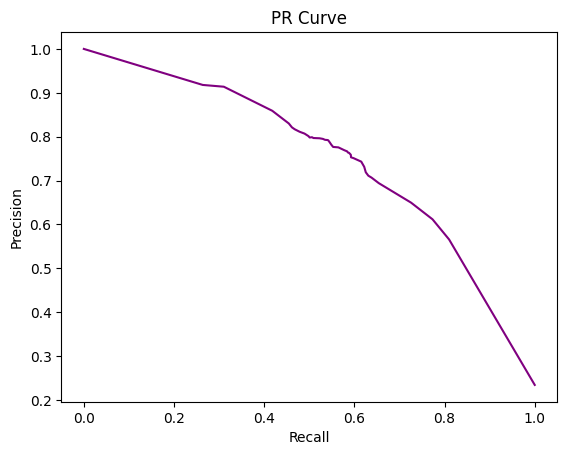

0.7518448309932487

In [55]:
# PR Curve

y_score = PredictRGS_probas(L,w,x_test)

precision1, recall1, thresholds1 = precision_recall_curve(y_test, y_score)
fig, ax  = plt.subplots()
ax.plot(recall1, precision1, color = "purple")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR Curve")
plt.show()

# AUC
auc(recall1, precision1)


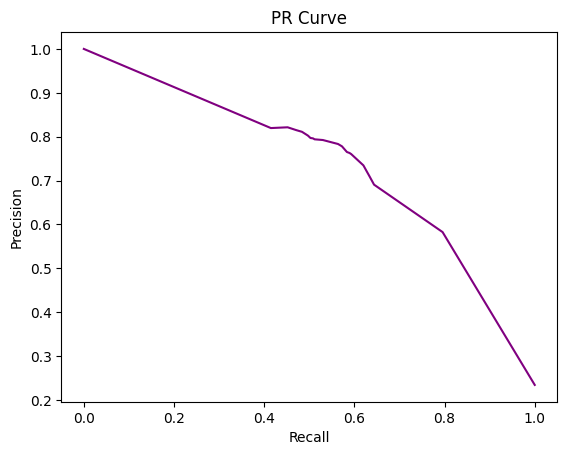

0.7372334120634363

In [56]:
# Selecting 28 random number between 0 and 49

r = random.sample(range(0, 60), 28)

w_random = []
for i in range(50):
    if i in r:
        w_random.append(1)
    else:
        w_random.append(0)

y_score = PredictRGS_probas(L,w_random,x_test)

precision3, recall3, thresholds3 = precision_recall_curve(y_test, y_score)
fig, ax  = plt.subplots()
ax.plot(recall3, precision3, color = "purple")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR Curve")
plt.show()
# AUC
auc(recall3, precision3)

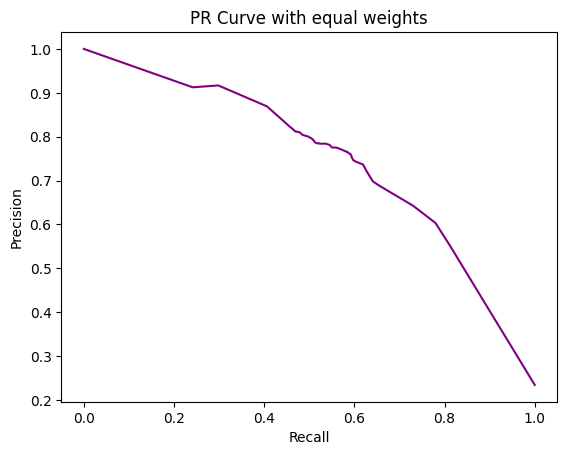

0.7476648158723189

In [57]:
w_1= np.ones(50)
# PR Curve with equal weights

y_score = PredictRGS_probas(L,w_1,x_test)

precision2, recall2, thresholds = precision_recall_curve(y_test, y_score)
fig, ax  = plt.subplots()
ax.plot(recall2, precision2, color = "purple")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR Curve with equal weights")
plt.show()

# AUC
auc(recall2, precision2)

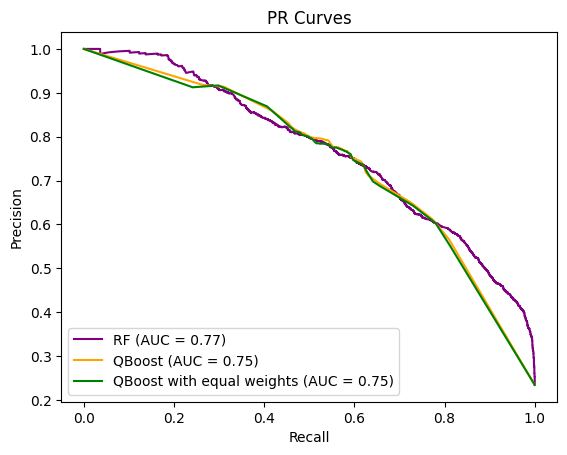

In [58]:
# Plotting PR curves of the RF and the QBoost on the same graph

fig, ax  = plt.subplots()
ax.plot(recall, precision, color = "purple", label = "RF")
ax.plot(recall1, precision1, color = "orange", label = "QBoost")
ax.plot(recall2, precision2, color = "green", label = "QBoost with equal weights")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR Curves")
ax.legend()

# Showing AUCs in the legend
auc_rf = auc(recall, precision)
auc_qboost = auc(recall1, precision1)
auc_qboost_equal = auc(recall2, precision2)
ax.legend(['RF (AUC = %0.2f)' % auc_rf, 'QBoost (AUC = %0.2f)' % auc_qboost, 'QBoost with equal weights (AUC = %0.2f)' % auc_qboost_equal])

plt.show()

In [59]:
# Autre idée d'algo

# Finding the max AUCPR

C = []
M = L.copy()
auc_pr_max = 0
max_id = 0
for clf in L:
    y_score = clf.predict_proba(x_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    auc_pr = auc(recall, precision)
    if auc_pr > auc_pr_max:
        auc_pr_max = auc_pr
        max_id = M.index(clf)
C.append(L[max_id])
M.pop(max_id)

marker = True
while marker:
    w_11 = np.ones(len(C))
    y_score = PredictRGS_probas(C,w_11,x_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    auc_pr = auc(recall, precision)
    auc_pr_max = auc_pr
    for j in range(len(L)):
        if j!=max_id:
            C.append(L[j])
            w_11 = np.ones(len(C))
            y_score = PredictRGS_probas(C,w_11,x_test)
            precision, recall, thresholds = precision_recall_curve(y_test, y_score)
            auc_pr = auc(recall, precision)
            if auc_pr > auc_pr_max:
                auc_pr_max = auc_pr
                max_id = j
            else:
                C.pop()
    if auc_pr_max == auc_pr:
        marker = False



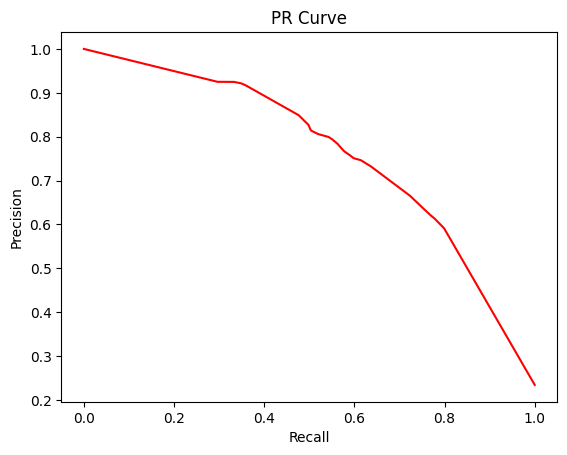

0.7637335407961505

In [67]:
w_11 = np.ones(len(C))
y_score = PredictRGS_probas(C,w_11,x_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fig, ax  = plt.subplots()
ax.plot(recall, precision, color = "red")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR Curve")
plt.show()

# AUC
auc(recall, precision)


In [60]:
# XGBoost 

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

param = {'max_depth': 5, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dtrain, 'train'), (dtest, 'eval')]

In [61]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-auc:0.88588	eval-auc:0.88864
[1]	train-auc:0.90674	eval-auc:0.90856
[2]	train-auc:0.91098	eval-auc:0.90991
[3]	train-auc:0.91699	eval-auc:0.91590
[4]	train-auc:0.91960	eval-auc:0.91731
[5]	train-auc:0.92244	eval-auc:0.91902
[6]	train-auc:0.92670	eval-auc:0.92272
[7]	train-auc:0.92781	eval-auc:0.92334


d:\Polytechnique\Stage 2A\SG\Code\env\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[8]	train-auc:0.92940	eval-auc:0.92514
[9]	train-auc:0.93096	eval-auc:0.92545


<Axes: >

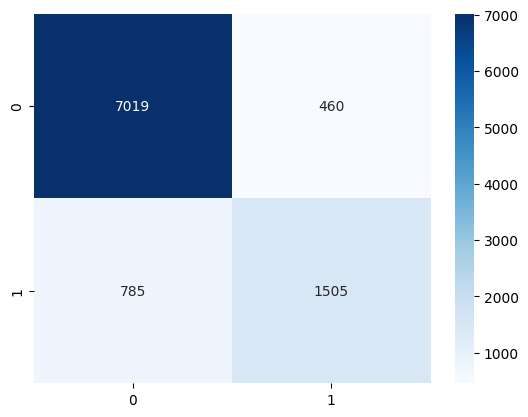

In [62]:
y_score = bst.predict(dtest)
y_pred = np.where(y_score > 0.5, 1, 0)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

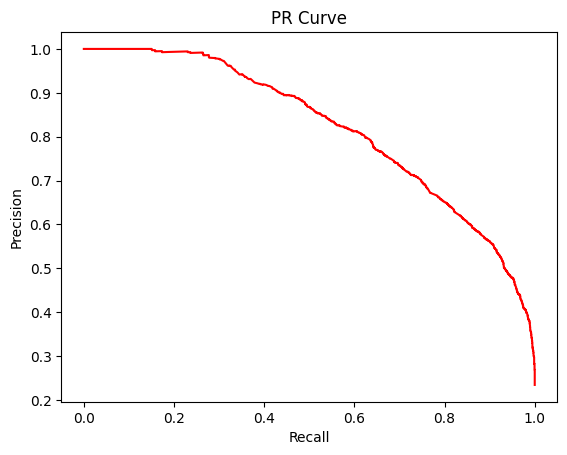

0.8199785635307234

In [63]:
# PR Curve

precision, recall, thresholds = precision_recall_curve(y_test, y_score)
fig, ax  = plt.subplots()
ax.plot(recall, precision, color = "red")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR Curve")
plt.show()
# AUC
auc(recall, precision)

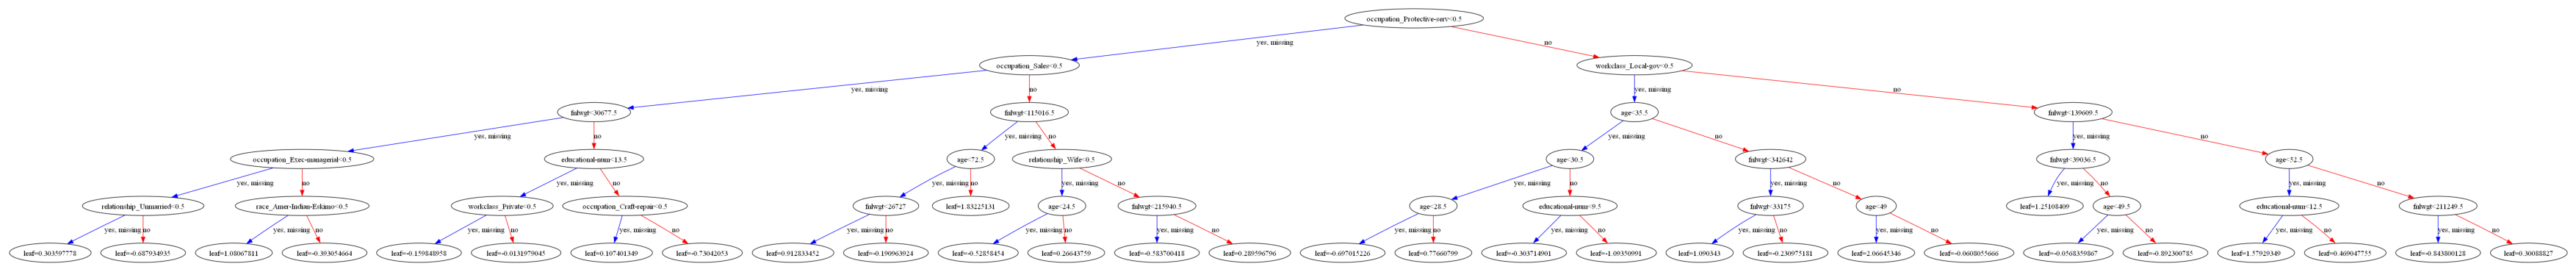

In [64]:
# Getting the tree models
import io
trees = bst.get_dump()
xgb.plot_tree(bst, num_trees=9)
#scaling larger
fig = plt.gcf()
fig.set_size_inches(45, 30)
fig.savefig('tree.png')